In [1]:
# Code by Youwei Liu
# Last Updated:July 7 2025
# this is a code to take in the balloon gps data and filter out the time when balloon is within the given radius of the station

from NuRadioReco.detector import detector
from rnog_analysis_tools.coordinate_system.coordinate_system import CoordinateSystem
import gzip
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone

class DetInfo:
    def __init__(self,  update_time=None):
        """
        Initialize DetInfo with station information from a detector file.

        Args:
            json_file (str): Path to the detector JSON file.
            update_time (datetime.datetime, optional): Date to update detector geometry. Default: 2023-10-01
        """
       #self.det = detector.Detector(source="rnog_mongo")
        self.det = detector.Detector(json_filename="/users/PAS2608/youwei/RNO_G/NuRadioMC/NuRadioReco/detector/RNO_G/RNO_season_2024.json")
        
        if update_time is None:
            update_time = datetime(2024, 9, 14)
        self.det.update(update_time)
        self.station_posi = {}  # Dictionary to hold station number -> (x, y, z)
        
    def load_station_coords(self, station_ids):
        """
        Load coordinates for the provided station IDs.

        Args:
            station_ids (list): List of station numbers to load coordinates for.
        """
        coordsys=CoordinateSystem()
        
        for station_id in station_ids:
            try:
                dis=self.det.get_absolute_position(station_id)
                self.station_posi[station_id] = tuple(dis)
                
            except Exception as e:
                print(f"Warning: Could not load position for station {station_id}: {e}")

    def get_station_position(self, station_id):
        """
        Get (x, y, z) position of a station.

        Args:
            station_id (int): Station number.

        Returns:
            tuple: (x, y, z) position in meters or None if not available.
        """
        #print(self.station_coords)
        return self.station_posi[station_id]


    def get_all_coords(self):
        """
        Return the dictionary of all loaded station coordinates.

        Returns:
            dict: station_id -> (x, y, z)
        """
        return self.station_posi


import successful


In [2]:


class Balloon:
    #note poistion third item is relative height to RNO-G station
    # where coord third item is altitude from sea level, which have 3200m in difference.
    def __init__(self):
        self.position=[]
        self.coord=[]
        self.times = []
        
        
    def load_balloon(self, file_name):
        """
        Load balloon GPS data from a .gpx.gz file.

        Args:
            file_name (str): Path to the .gpx.gz file
        """
        

        with gzip.open(file_name, 'rb') as f:
            tree = ET.parse(f)
            root = tree.getroot()
            coordsys=CoordinateSystem()
            # GPX files usually have namespaces
            ns = {'default': 'http://www.topografix.com/GPX/1/1'}

            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.attrib['lat'])
                lon = float(trkpt.attrib['lon'])
                ele_elem = trkpt.find('default:ele', ns)
                time_elem = trkpt.find('default:time', ns)

                if ele_elem is not None and time_elem is not None:
                    ele = float(ele_elem.text)
                    time = datetime.fromisoformat(time_elem.text.replace("Z", "+00:00"))
                    self.position.append(coordsys.geodetic_to_enu(lat,lon,ele)[0:3])
                    self.coord.append([lat,lon,ele])
                    self.times.append(time)

    def get_position(self):
        """
        Return list of (east,north,height) tuples.

        Returns:
            list of tuples
        """
        return self.position

    def get_times(self):
        """
        Return list of datetime objects.

        Returns:
            list of datetime.datetime
        """
        return self.times

    def plot_path_with_stations(self, det, fig_name='Balloon_trace_and_station.png'):
        """
        Plot the GPS track of the balloon along with RNO-G station positions.

        Args:
            det (Detector): A NuRadioReco Detector object with station geometry loaded.
        """
        gpx_lats = [coord[0] for coord in self.coord]
        gpx_lons = [coord[1] for coord in self.coord]
        coordsys=CoordinateSystem()
        
        # Station positions
        station_latlon = []
        for station_id in det.station_posi:
            x, y, z = det.get_station_position(station_id)
            lat, lon, _ = coordsys.enu_to_geodetic(x, y, z)
            station_latlon.append((lat, lon))
        station_lats, station_lons = zip(*station_latlon)

        # Plotting
        plt.figure(figsize=(10, 8))
        plt.plot(gpx_lons, gpx_lats, 'b-', label='GPS Track', alpha=0.7)
        plt.plot(gpx_lons, gpx_lats, 'b.', markersize=2, alpha=0.5)
        plt.plot(station_lons, station_lats, 'ro', markersize=8, label='RNO-G Stations')
        plt.xlabel('Longitude (degrees)')
        plt.ylabel('Latitude (degrees)')

        plt.xlabel('Longitude (degrees)', fontsize=14)
        plt.ylabel('Latitude (degrees)', fontsize=14)
        plt.title('GPS Track and RNO-G Station Locations', fontsize=16)

        # optional:
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        
        plt.title('GPS Track and RNO-G Station Locations')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.gca().set_aspect(1 / np.cos(np.mean(gpx_lats) * np.pi / 180))
        plt.tight_layout()
        plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def compute_zenith_angle(ch_coord, balloon_coord):
        """
        Compute the zenith angle of the balloon relative to a channel.

        Parameters
        ----------
        ch_coord : tuple or list
            Channel coordinate (x, y, z) in meters.
        balloon_coord : tuple or list
            Balloon coordinate (x, y, z) in meters.

        Returns
        -------
        float
            Zenith angle in degrees (0° = directly overhead, 90° = on the horizon).
        """
        ch_coord = np.array(ch_coord)
        balloon_coord = np.array(balloon_coord)

        vec = balloon_coord - ch_coord
        distance = np.linalg.norm(vec)
        dz = vec[2]

        if distance == 0:
            raise ValueError("Channel and balloon coordinates are identical (distance=0).")

        return np.degrees(np.arccos(dz / distance))

    def export_coords_every_minute(self, start_time, end_time, ch_coord,
                                   output_file="balloon_coords_zenith.txt",
                                   time_step=0.1):
        """
        Print and export balloon coordinates and zenith angle at fixed time intervals.
    
        Parameters
        ----------
        start_time : datetime or float
            Start time (UTC). Can be datetime object or Unix timestamp.
        end_time : datetime or float
            End time (UTC). Can be datetime object or Unix timestamp.
        ch_coord : tuple or list
            Channel coordinate (x, y, z) in meters.
        output_file : str, optional
            Output filename for saving the results.
        time_step : float, optional
            Time interval in **minutes** between consecutive samples (default: 0.1 min = 6 s).
    
        Returns
        -------
        pandas.DataFrame
            Columns: Time(UTC), Latitude, Longitude, Height(m), ZenithAngle(deg), X(m), Y(m)
            (No Z column in the DataFrame.)
        """
        import numpy as np
        import pandas as pd
        from datetime import datetime
    
        coordsys = CoordinateSystem()
    
        # --- convert to timestamps ---
        start_ts = start_time.timestamp() if isinstance(start_time, datetime) else float(start_time)
        end_ts   = end_time.timestamp()   if isinstance(end_time, datetime)   else float(end_time)
    
        times = np.array(self.times)
        if times.size == 0 or len(self.coord) == 0:
            raise ValueError("No balloon data loaded. Run load_balloon() first.")
    
        # Convert to timestamps if they are datetime objects
        if isinstance(times[0], datetime):
            times = np.array([t.timestamp() for t in times])
    
        coords = np.asarray(self.coord)  # rows like [lat, lon, height]
    
        # --- iterate over requested times, collect rows ---
        rows = []
        step_seconds = float(time_step) * 60.0  # minutes → seconds
        current_time = start_ts
    
        while current_time <= end_ts:
            idx = int(np.argmin(np.abs(times - current_time)))  # closest timestamp
            closest_time = float(times[idx])
            lat, lon, height = coords[idx]
    
            # ENU position relative to station origin
            x, y, z = coordsys.geodetic_to_enu(lat, lon, height)
    
            zenith_angle = self.compute_zenith_angle(ch_coord, (x, y, z))
            utc_str = datetime.utcfromtimestamp(closest_time).strftime("%Y-%m-%d %H:%M:%S")
    
            rows.append(
                {
                    "Time(UTC)": utc_str,
                    "Latitude": float(lat),
                    "Longitude": float(lon),
                    "Height(m)": float(z),            # keep behavior: ENU Z as "Height"
                    "ZenithAngle(deg)": float(zenith_angle),
                    "X(m)": float(x),
                    "Y(m)": float(y),
                }
            )
    
            current_time += step_seconds
    
        # --- DataFrame (no Z column) ---
        df = pd.DataFrame(rows, columns=[
            "Time(UTC)", "Latitude", "Longitude", "Height(m)", "ZenithAngle(deg)", "X(m)", "Y(m)"
        ])
    
        # Nicely formatted printout: keep X and Y in the print
        fmt = {
            "Latitude":         "{:.6f}".format,
            "Longitude":        "{:.6f}".format,
            "Height(m)":        "{:.2f}".format,
            "ZenithAngle(deg)": "{:.2f}".format,
            "X(m)":             "{:.3f}".format,
            "Y(m)":             "{:.3f}".format,
        }
        print(df.to_string(index=False, formatters=fmt))
    
        # --- save to text file (original 5 columns for compatibility) ---
        df_out = df[["Time(UTC)", "Latitude", "Longitude", "Height(m)", "ZenithAngle(deg)","X(m)","Y(m)"]].copy()
        # round for file output to match your previous formatting
        df_out["Latitude"]         = df_out["Latitude"].round(6)
        df_out["Longitude"]        = df_out["Longitude"].round(6)
        df_out["Height(m)"]        = df_out["Height(m)"].round(2)
        df_out["ZenithAngle(deg)"] = df_out["ZenithAngle(deg)"].round(2)
        df_out["X(m)"]         = df_out["X(m)"].round(3)
        df_out["Y(m)"]        = df_out["Y(m)"].round(3)
        df_out.to_csv(output_file, sep="\t", index=False)
    
        print(f"[INFO] Exported {len(df)} points to {output_file}")
        return df


In [3]:
def get_balloon_station_times(detector_info, balloon, radius, step_size=100,time_step=0.05):
    """
    Optimized and extended: For each station, find all time intervals when the balloon is
    within horizontal `radius` (ignoring height), using stepped search and refinement.

    Args:
        detector_info (DetInfo): Station geometry provider.
        balloon (Balloon): Balloon object with `.position` and `.times`.
        radius (float): Distance threshold in meters (2D).
        step_size (int): Interval to scan positions quickly.

    Returns:
        dict: {station_id: [(start_time1, end_time1), (start_time2, end_time2), ...]}
    """
    results = {}
    radius2 = radius ** 2  # Use squared distance for efficiency

    balloon_xy = np.array(balloon.position)[:, :2]  # Only use (x, y)
    balloon_times = np.array(balloon.times)
    N = len(balloon_xy)

    for station_id in detector_info.station_posi:
        sx, sy, _ = detector_info.get_station_position(station_id)
        station_xy = np.array([sx, sy])

        # Step-wise scan: check every `step_size` samples
        in_range_flags = []
        for i in range(0, N, step_size):
            dx, dy = balloon_xy[i] - station_xy
            dist2 = dx * dx + dy * dy
            in_range_flags.append(dist2 <= radius2)

        intervals = []  # Store (start_idx, end_idx) of in-range periods

        # Detect rising and falling edges (entry/exit)
        in_range = False
        for j in range(len(in_range_flags) - 1):
            i0 = j * step_size
            i1 = min((j + 1) * step_size, N)

            entering = not in_range_flags[j] and in_range_flags[j + 1]
            exiting = in_range_flags[j] and not in_range_flags[j + 1]
            inside = in_range_flags[j] and in_range_flags[j + 1]

            if entering or inside:
                # Refine start if entering
                if not in_range:
                    for k in range(i0, i1):
                        dx, dy = balloon_xy[k] - station_xy
                        if dx * dx + dy * dy <= radius2:
                            start_idx = k
                            in_range = True
                            break
                # If already inside, do nothing
            if exiting or (j + 1 == len(in_range_flags) - 1 and in_range):
                # Refine end
                for k in reversed(range(i0, i1)):
                    dx, dy = balloon_xy[k] - station_xy
                    if dx * dx + dy * dy <= radius2:
                        end_idx = k
                        intervals.append((balloon_times[start_idx], balloon_times[end_idx]))
                        in_range = False
                        break

        if intervals:
            results[station_id] = intervals

    for station, intervals in results.items():
        for t_start, t_end in intervals:
            # Find corresponding indices
            start_idx = balloon_times.tolist().index(t_start)
            end_idx = balloon_times.tolist().index(t_end)
    
            # Get corresponding altitudes (height = 3rd element in coord)
            height_start = balloon.position[start_idx][2]
            height_end = balloon.position[end_idx][2]
    
            print(f"Station {station}: from {t_start} to {t_end}")
            print(f"    Entry height: {height_start:.2f} m")
            print(f"    Exit  height: {height_end:.2f} m")

    return results


In [4]:
# Initialize
detinfo = DetInfo()

# Load coordinates for a list of stations
detinfo.load_station_coords([11,12,13,14,21,22,23])



# Get position of station 2
print("Station 21 position:", detinfo.get_station_position(21))

# Example: channel coordinate
station7_coord = detinfo.get_station_position(21) + detinfo.det.get_relative_position(21, 7)


# Get all loaded positions
print("All station coordinates:", detinfo.get_all_coords())


Station 21 position: (np.float64(-308.1768397289919), np.float64(495.8958356648789), np.float64(-3.001389475218261))
All station coordinates: {11: (np.float64(-1572.8161736544128), np.float64(729.3722386485937), np.float64(-3.783231150073059)), 12: (np.float64(-1352.364325059356), np.float64(1911.1738485252934), np.float64(-4.03610097553792)), 13: (np.float64(-1147.4927545674973), np.float64(3124.0456946337963), np.float64(-4.50342952129995)), 14: (np.float64(-949.2831612560908), np.float64(4401.210831129985), np.float64(-1.5853338618655926)), 21: (np.float64(-308.1768397289919), np.float64(495.8958356648789), np.float64(-3.001389475218261)), 22: (np.float64(-138.03400922620767), np.float64(1708.005557160627), np.float64(-2.463255858468301)), 23: (np.float64(82.4071346964168), np.float64(2949.9982332582017), np.float64(-2.837141509331976))}


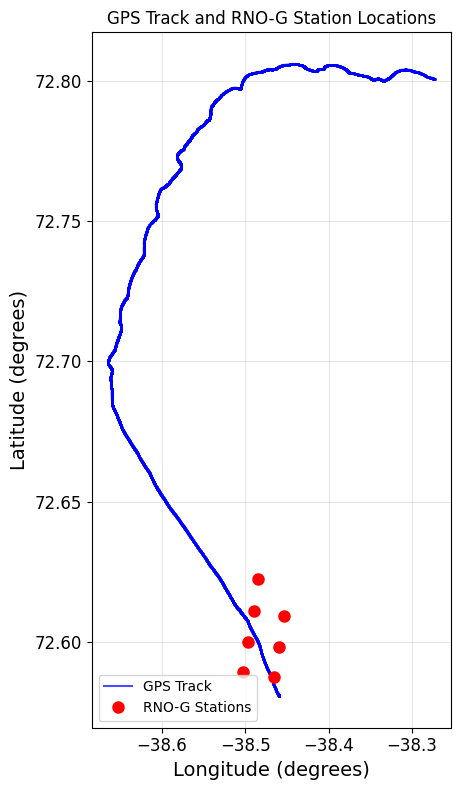

          Time(UTC)  Latitude  Longitude Height(m) ZenithAngle(deg)      X(m)      Y(m)
2022-09-29 23:15:00 72.580929 -38.459894      0.21            86.72  -136.417  -208.071
2022-09-29 23:15:03 72.580936 -38.459891     -1.01            86.81  -136.317  -207.290
2022-09-29 23:15:06 72.580939 -38.459882     -1.72            86.87  -136.016  -206.955
2022-09-29 23:15:09 72.580940 -38.459880      0.13            86.72  -135.949  -206.843
2022-09-29 23:15:12 72.580944 -38.459889      4.78            86.35  -136.250  -206.397
2022-09-29 23:15:15 72.580947 -38.459868      7.23            86.16  -135.548  -206.062
2022-09-29 23:15:18 72.580950 -38.459839      7.89            86.10  -134.578  -205.727
2022-09-29 23:15:21 72.580951 -38.459826      7.28            86.15  -134.143  -205.616
2022-09-29 23:15:24 72.580951 -38.459814      6.52            86.21  -133.742  -205.616
2022-09-29 23:15:27 72.580949 -38.459792      3.18            86.48  -133.006  -205.839
2022-09-29 23:15:30 72.580948 -3

In [5]:
balloon = Balloon()
balloon.load_balloon('gps_file/SMT_20220929_231830.gpx.gz')

coords = balloon.get_position()
times = balloon.get_times()

balloon.plot_path_with_stations(detinfo)
# print("First coordinate:", coords[5100])
# print("First coordinate:", coords[5000])
# print("First timestamp:", times[0])
# print("First timestamp:", times[1000])

# Assume balloon.load_balloon() has been called already
start_dt = datetime(2022, 9, 29, 23, 15, tzinfo=timezone.utc)
end_dt   = datetime(2022, 9, 29, 23, 55, tzinfo=timezone.utc)

station7_coord = detinfo.get_station_position(21) + detinfo.det.get_relative_position(21, 7)

balloon.export_coords_every_minute(start_dt, end_dt, station7_coord,
                                   output_file="balloon_minute_coords_zenith_DF.txt",time_step=0.05)

radius_m = 400  # meters

station_results = get_balloon_station_times(detinfo, balloon, radius_m)



In [6]:
# balloon = Balloon()
# balloon.load_balloon('gps_file/SMT_20230810_112357.gpx.gz')

# coords = balloon.get_position()
# times = balloon.get_times()

# balloon.plot_path_with_stations(detinfo)
# # print("First coordinate:", coords[5100])
# # print("First coordinate:", coords[5000])
# # print("First timestamp:", times[0])
# # print("First timestamp:", times[1000])


# radius_m = 200  # meters

# station_results = get_balloon_station_times(detinfo, balloon, radius_m)